In [11]:
import astropy.units as U
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.constants import c
from collections import OrderedDict
import h5py
import illustris_python as il
from random import choices
import sys
import os
import numpy as np
import pandas as pd 
from scipy.optimize import curve_fit
import random
import shutil
from os.path import isfile, expanduser
import subprocess
import six
from math import pi, ceil
import matplotlib.pyplot as plt
from tqdm import tqdm
from dl import queryClient as qc, storeClient as sc, authClient as ac
from pyvo.dal import sia
from astropy.utils.data import download_file, import_file_to_cache
from numpy.core.defchararray import startswith
import pylab as plt
from getpass import getpass
import warnings  
from astropy.utils.exceptions import AstropyWarning
from astroquery.sdss import SDSS
import matplotlib.image as plimg
from scipy.ndimage import zoom 


In [12]:
def gaussian(x, amp, cen, fwhm):
    """
    Generates a 1D Gaussian given the following input parameters:
    x: position
    amp: amplitude
    fwhm: fwhm
    """
    #def integrand(x, amp, cen, fwhm):
    #    return np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))
    #integral, _ = quad(integrand, -np.inf, np.inf, args=(1, cen, fwhm))
    gaussian = np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))
    if np.sum(gaussian) != 0:
        norm = amp /  np.sum(gaussian)
    else:
        norm = amp
    result = norm * gaussian
    #norm = 1 / integral
    return result

def interpolate_array(arr, n_px):
    """Interpolates a 2D array to have n_px pixels while preserving aspect ratio."""
    zoom_factor = n_px / arr.shape[0]
    print(zoom_factor)
    return zoom(arr, zoom_factor)

0.6037735849056604
1.0


100%|██████████| 256/256 [00:00<00:00, 2537.62it/s]

390.0 389.9999947631915


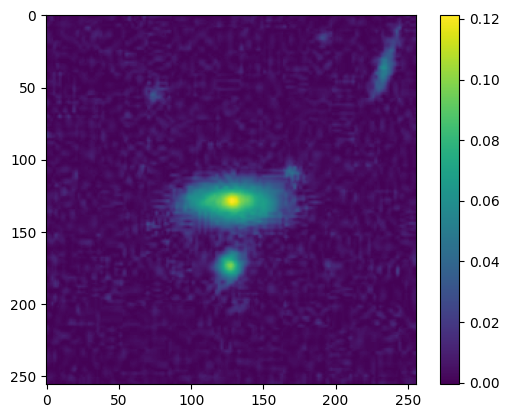

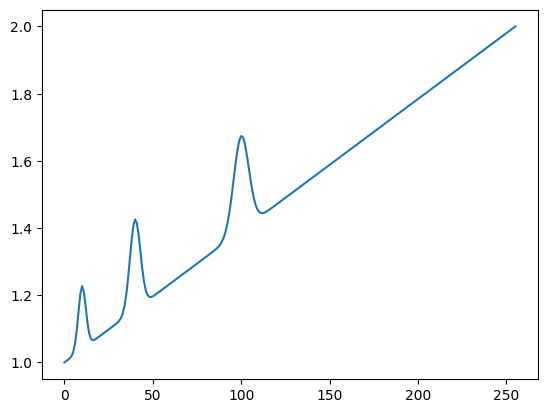

In [48]:
data_path = '/Users/michele/Downloads/GalaxyZooArchive/images_gz2/images'
files = np.array(os.listdir(data_path))
imfile = os.path.join(data_path, np.random.choice(files))
n_chan = 256
n_px = 256
img = plimg.imread(imfile).astype(np.float32)
dims = np.shape(img)
d3 = min(2, dims[2])
d1 = float(max(dims))
avimg = np.average(img[:, :, :d3], axis=2)
avimg -= np.min(avimg)
avimg *= 1 / np.max(avimg)
avimg = interpolate_array(avimg, n_px)
avimg /= np.sum(avimg)
print(np.sum(avimg))
line_fluxes = [1, 2, 3]
pos_z = [ 10, 40, 100]
fwhm_z = [5, 7, 10]
cont = np.linspace(1, 2, n_chan)

datacube = np.zeros((n_px, n_px, n_chan))
X, Y = np.meshgrid(np.arange(n_px), np.arange(n_px))
z_idxs = np.arange(0, n_chan)
gs = np.zeros(n_chan)
for i in range(len(line_fluxes)):
    gs += gaussian(z_idxs, line_fluxes[i], pos_z[i], fwhm_z[i])
for z in tqdm(range(0, n_chan)):
    datacube[:, :, z] += avimg * (cont[z] + gs[z]) 

print(np.sum(cont) + np.sum(gs), np.sum(datacube))


img = np.sum(datacube, axis=2)
plt.imshow(img)
plt.colorbar()
plt.show()

spectrum = np.sum(datacube, axis=(0, 1))
plt.plot(spectrum)
plt.show()


In [8]:
import os
import zipfile
from kaggle import api

def unzip_all(zip_filepath):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall()
    
def download_kaggle_dataset(save_path):
    """Downloads a Kaggle dataset to the specified path.

    Args:
        dataset_name (str): The name of the dataset in the format 'username/dataset-name'.
        save_path (str): The directory where the dataset should be saved.
    """
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    api.authenticate()  # Authenticate with your Kaggle credentials
    dataset_name = 'jaimetrickz/galaxy-zoo-2-images'
    # Download the dataset as a zip file
    api.dataset_download_files(dataset_name, path=save_path, unzip=True)
    print(f"Dataset '{dataset_name}' downloaded to '{save_path}'")
    print('Unzipping .....')
    unzip_all(os.path.join(save_path, 'galaxy-zoo-2-images.zip'))


dataset_name = 
path = 'galaxy-zoo'
download_kaggle_dataset(dataset_name, path)

Dataset URL: https://www.kaggle.com/datasets/jaimetrickz/galaxy-zoo-2-images


KeyboardInterrupt: 

In [7]:

unzip_all('galaxy-zoo/galaxy-zoo-2-images.zip')

BadZipFile: File is not a zip file

In [42]:
from scipy.ndimage.interpolation import rotate
from scipy.spatial.transform import Rotation
def rotate_galaxy_cube(galaxy_cube, pa, reshape=False):
    """
    Rotates a 3D galaxy cube by the projection angle (PA) along the z-axis (line of sight).

    Args:
        galaxy_cube (np.ndarray): The 3D array representing the galaxy.
        pa (float): Projection angle in degrees (counterclockwise from the positive x-axis).
        reshape (bool, optional): Whether to reshape the output to fit the rotated galaxy. 
                                   Default is False (preserves original array shape).

    Returns:
        np.ndarray: The rotated galaxy cube.
    """
    random_angle = np.random.uniform(0, 360)
    original_shape = galaxy_cube.shape
    print(random_angle)
    rotated_cube = rotate(galaxy_cube, random_angle, axes=(1, 0), reshape=reshape)  # Rotate along z-axis
    indices = np.indices(rotated_cube.shape).reshape(3, -1).T
    rotation = Rotation.from_euler('z', pa, degrees=True)
    # Apply the rotation to each point (x, y, z) in the cube
    rotated_indices = rotation.apply(indices).astype(int)
    rotated_indices[:, 0] = np.clip(rotated_indices[:, 0], 0, original_shape[0] - 1)
    rotated_indices[:, 1] = np.clip(rotated_indices[:, 1], 0, original_shape[1] - 1)
    rotated_indices[:, 2] = np.clip(rotated_indices[:, 2], 0, original_shape[2] - 1)
    rotated_cube = np.zeros(rotated_cube.shape)
    
    rotated_cube[rotated_indices[:, 0], rotated_indices[:, 1], rotated_indices[:, 2]] = rotated_cube.ravel()
    # Reshape back to the original cube dimensions
    return rotated_cube

/var/folders/66/76q50s015tq8wc5qz1pvg7y40000gn/T/ipykernel_1836/305515474.py:1: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import rotate


6.295424146912585


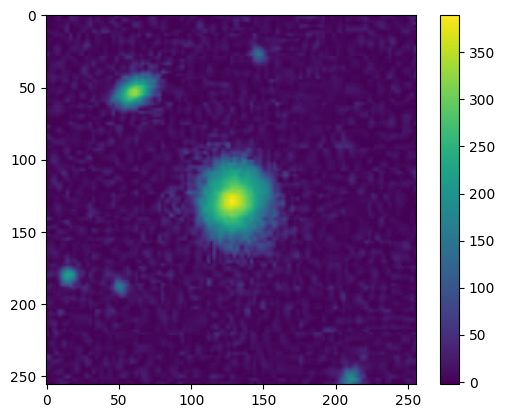

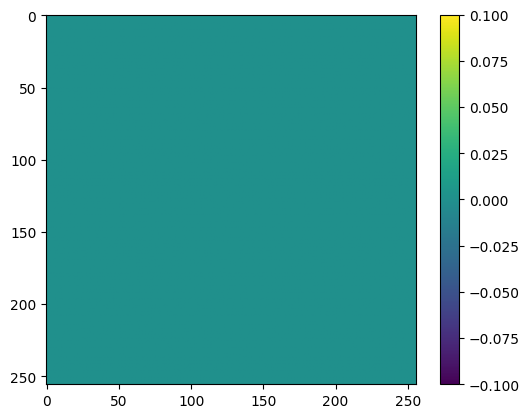

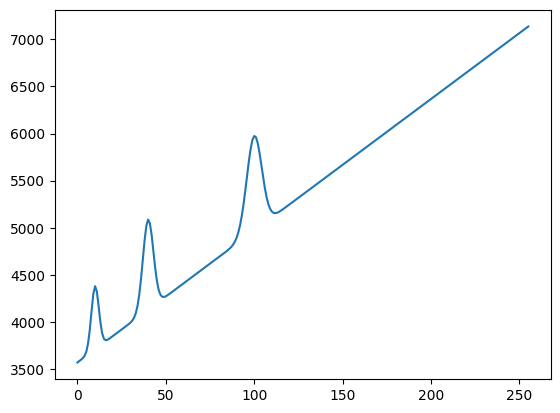

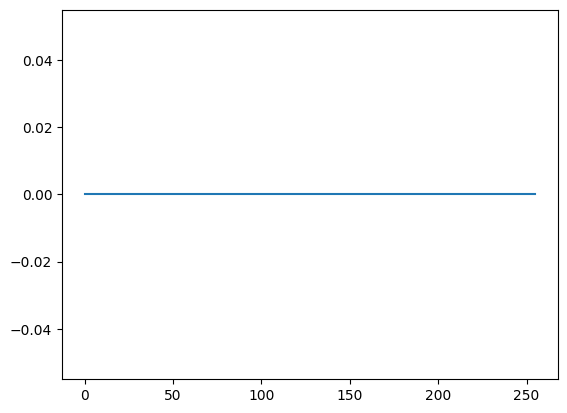

In [43]:
rotated_cube = rotate_galaxy_cube(datacube, 15)
img = np.sum(datacube, axis=2)
plt.imshow(img)
plt.colorbar()
plt.show()

img = np.sum(rotated_cube, axis=2)
plt.imshow(img)
plt.colorbar()
plt.show()

spectrum = np.sum(datacube, axis=(0, 1))
plt.plot(spectrum)
plt.show()

spectrum = np.sum(rotated_cube, axis=(0, 1))
plt.plot(spectrum)
plt.show()